# Evaluation

---

# Outline

**For single image query region of interest.**

1. i.e. which parts belong to the desired house?
2. Identify the individual properties (roughly)

**Ideas:**

1. similar approach as in the image cover calculations:  
   Use physics, to calculate raster (maybe start with 1 m resolution)
2. Match with puplic property data
3. For this house query individual categories of annotations (roof, wall, window, etc.)
4. Query temperature of those values.
5. Calc Average, Min, Max, Outliers (by threshhold)

# Input

* Images and Annotations

Start with images 22,24,26

# Test With dorfstr6 image

### Steps:
* [x] Wie genau sind die Annotation Segmentation werte zu lesen.
* [x] Masken generieren mit `pycocotools` und mit opencv pixelwerte querien. mit methodik vertaut machen.
* [ ] Build methodology for applying this to temp values
    * [ ] **This effectlively means to deal with the thermal container and split it up.**
* [ ] Build workflow and potentially toolbox with nbdev.
* [ ] *Later...* fenstergrößen etc abschätzen und mit data base kombinieren.

### Annotations:
In den Annotations (`dict`) ist der `segmentation` Eintrag der Enscheidende.\
Dieser ist entweder eine `list` oder ein `dict`\
`list` bedeutet, es handelt sich um ein polygon o.ä.\
`dict` bedeutedt es handelt sich um eine maske im rle format (Run-Length-Encoding)\
`pycocotools` bieten einen guten converter zu masken.
`bbox` und float sind als koordinaten paare zu lesen (0,0) normalerweise top-left

In [211]:
import os
import json
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2 as cv

In [275]:
json_file: str = '/data/auswertung/dorfstr_6/dorfstr_6_annotations.json'
coco = COCO(json_file);

with open(json_file, 'r') as file:
    data = json.load(file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## single image roof

In [282]:
# meta data image
image = data['images'][0]

# image annotation data
image_anns = [ann for ann in data['annotations'] if ann['image_id'] == image['id']]

In [285]:
# Get ID of desired category
cat_name: str = 'roof'
cat_id = [cat['id'] for cat in data['categories'] if cat['name'] == cat_name][0] # This loop is reaccurent and thus quite ineffective.

# Query for annotations of desired category
image_roof = [ann for ann in image_anns if ann['category_id'] == cat_id] # This loop is reaccurent and thus quite ineffective.
# image_roof

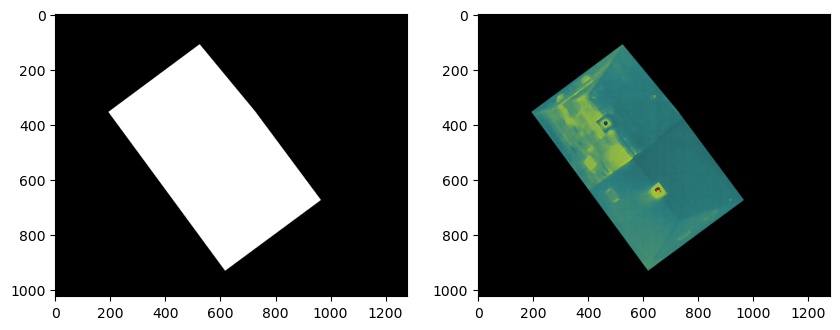

In [284]:
# Create Mask and put it in format values={0,255}
mask  = coco.annToMask(image_roof[0])
retval, mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY)

# Apply Mask to image
thermal = cv.imread(f'/data/auswertung/dorfstr_6/{image['file_name']}')
thermal = cv.bitwise_and(thermal, thermal, mask=mask)

# Plot Result
plt.figure(figsize=[10, 5])
plt.subplot(121);plt.imshow(mask, cmap='gray');
plt.subplot(122);plt.imshow(thermal[:,:,::-1]);

## Merge all windows into one Mask

In [287]:
# meta data image
image = data['images'][0]

# image annotation data
image_anns = [ann for ann in data['annotations'] if ann['image_id'] == image['id']]

# Print out category_id & category name
for ann in image_anns:
    print('Annotation:', ann['id'], '; Category:',ann['category_id'], data['categories'][ann['category_id']-1]['name'])
    # print(data['categories'][ann['category_id']-1]['name'])

Annotation: 1 ; Category: 2 window
Annotation: 2 ; Category: 2 window
Annotation: 3 ; Category: 2 window
Annotation: 4 ; Category: 2 window
Annotation: 5 ; Category: 5 roof
Annotation: 6 ; Category: 4 chimney
Annotation: 7 ; Category: 4 chimney


In [290]:
# Get ID of desired category
cat_name: str = 'window'
cat_id = [cat['id'] for cat in data['categories'] if cat['name'] == cat_name][0] # This loop is reaccurent and thus quite ineffective.

# Query for annotations of desired category
image_windows = [ann for ann in image_anns if ann['category_id'] == cat_id] # This loop is reaccurent and thus quite ineffective.

In [291]:
# Create merged mask and put it in format values={0,255} (opencv needs this to work properly)
mask = np.zeros((image['height'], image['width']), dtype=np.uint8)
for ann in image_windows:
    mask = cv.add(mask, coco.annToMask(ann))

retval, mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY)

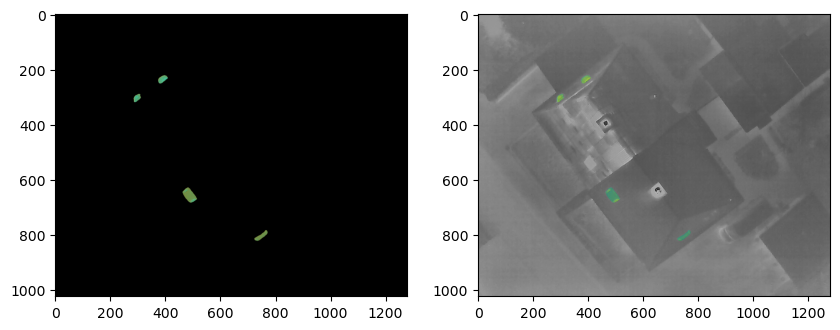

In [292]:
# Apply Mask to image
thermal = cv.imread(f'/data/auswertung/dorfstr_6/{image['file_name']}')
thermal = cv.bitwise_and(thermal, thermal, mask=mask)

# Create Gray Background from inverted mask
thermal_back = cv.imread(f'/data/auswertung/dorfstr_6/{image['file_name']}', cv.IMREAD_GRAYSCALE)
thermal_back = cv.bitwise_and(thermal_back, thermal_back, mask=mask_inv)
thermal_back = cv.cvtColor(thermal_back, cv.COLOR_GRAY2BGR)

# Plot Result
plt.figure(figsize=[10, 5])
plt.subplot(121);plt.imshow(thermal);
plt.subplot(122);plt.imshow(cv.add(thermal, thermal_back)[:,:,::-1]);